# Music machine learning - Adversarial learning

### Author: Philippe Esling (esling@ircam.fr)

Generative adversarial networks (GANs) are neural networks that generate material, such as images, music, speech, or text, that is similar to what humans produce.

In this course we will cover
1. The global principle of [adversarial learning](#adversarial)
2. How to train your own GAN on a [toy dataset](#toy)
3. A practical example on [MNIST](#mnist) using PyTorch

<a id="adversarial"></a>
## Adversarial learning

This is the code used in first example of the article [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/) on Real Python.

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
hdr_plot_style()

Generative adversarial networks (GANs) are machine learning systems that can learn to mimic a given distribution of data. GANs consist of two neural networks, one trained to *generate* data and the other trained to *discriminate* fake data from real data (hence the “adversarial” nature of the model).

GANs require to define two neural networks, one called the *generator* and the other called the *discriminator*. The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

These two networks define a *zero-sum game* as they are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

## Training GANs on a toy dataset

To understand how GAN training works, consider a toy example with a dataset composed of two-dimensional samples $(x_{1}, x_{2})$, with $x_{1}$ in the interval from $0$ to $2\pi$ and $x_{2} = sin(x_{1})$, as illustrated in the following 

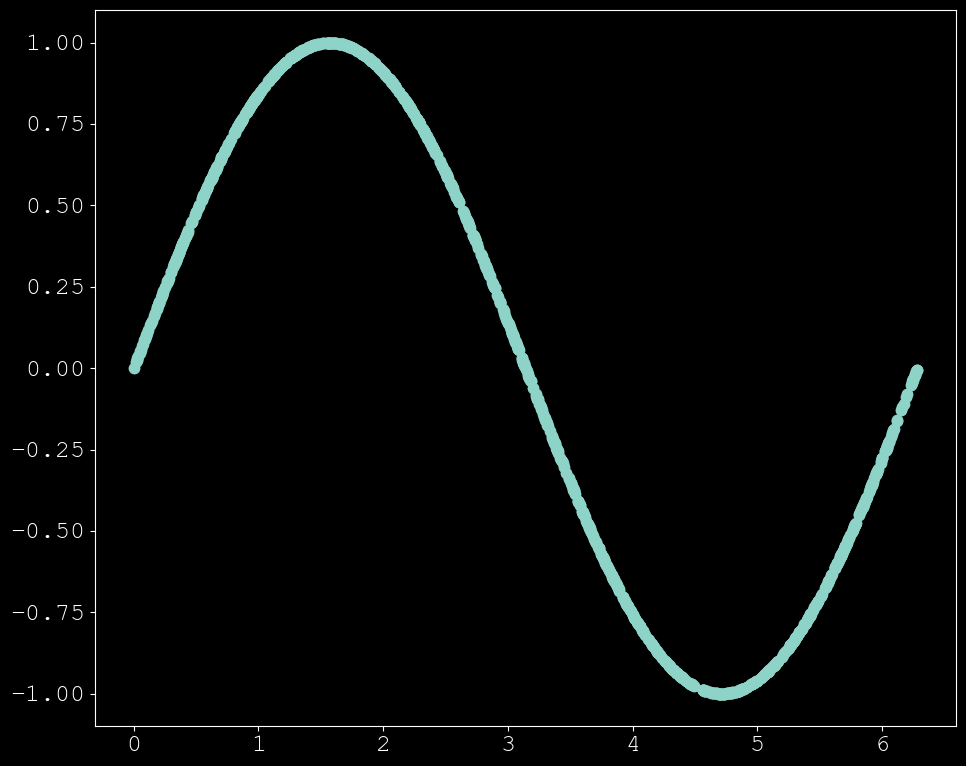

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])
train_labels = torch.zeros(train_data_length)
trainset = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
plt.figure(figsize=(10,8))
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.tight_layout()

As usual, we need to define a `DataLoader` that will provide us with the training data in different batches.

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

First, we define the generator, which is fed with random data from a latent space. Its role is to generate data resembling the real samples. In this example, you have a two-dimensional latent space, so that the generator is fed with random $(z_{1}, z_{2})$ pairs and is required to transform them so that they resemble the real samples.

We can define any type of network in the generator, given that it has sufficient complexity to generate the underlying type of data.

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),            
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [5]:
generator = Generator()

In turn, the discriminator is fed with either real samples from the training dataset or generated samples provided by the generator. Its role will be to estimate the probability that the input belongs to the real dataset or is a generated one. The training is performed so that the discriminator outputs 1 when it is fed a real sample and 0 when it is fed a generated sample. Again, we can choose any architecture of our liking for this network.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

We can now define our training hyper-parameters that will condition the learning procedure.

In [8]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

The training procedure is defined as follows

In [9]:
loss_d = torch.zeros(int(num_epochs / 10))
loss_g = torch.zeros(int(num_epochs / 10))
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        
        # zero the parameter gradients
        optimizer_discriminator.zero_grad()
        
        # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
        batch_size = real_samples.size(0)
        noise = torch.randn(batch_size, 2)
        fake_samples = generator(noise)
        
        # forward du discriminator
        disc_real_output = discriminator(real_samples)
        disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas besoin d'avoir accès au gradient du generateur
        
        # calculate the loss for the discriminator
        loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
        
        # calculate the gradient for the discriminator
        loss_discriminator.backward()  
        
        # update the discriminator first
        optimizer_discriminator.step()
        
        
        # zero the parameter gradients
        optimizer_generator.zero_grad()

        # forward du discriminator
        # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
        disc_fake_output = discriminator(fake_samples)
        
        # calculate the loss for the generator
        loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
        
        # calculate the gradient for the discriminator
        loss_generator.backward() 
        
        # update the generator
        optimizer_generator.step()

    # Show loss
    if epoch % 10 == 0 and n == batch_size - 1:
        loss_d[int(epoch / 10)] = loss_discriminator
        loss_g[int(epoch / 10)] = loss_generator

        print("Epoch: {}".format(epoch))
        print("Generator loss: {:.4f},  Discriminator loss: {:.4f}".format(loss_generator, loss_discriminator))

Epoch: 0
Generator loss: 2.1802,  Discriminator loss: 0.1942
Epoch: 10
Generator loss: 0.8952,  Discriminator loss: 0.6018
Epoch: 20
Generator loss: 0.7379,  Discriminator loss: 0.6925
Epoch: 30
Generator loss: 0.8623,  Discriminator loss: 0.6395
Epoch: 40
Generator loss: 0.8726,  Discriminator loss: 0.6385
Epoch: 50
Generator loss: 0.7921,  Discriminator loss: 0.7221
Epoch: 60
Generator loss: 0.9112,  Discriminator loss: 0.5721
Epoch: 70
Generator loss: 0.7399,  Discriminator loss: 0.6724
Epoch: 80
Generator loss: 0.8377,  Discriminator loss: 0.6785
Epoch: 90
Generator loss: 0.7206,  Discriminator loss: 0.6978
Epoch: 100
Generator loss: 0.7525,  Discriminator loss: 0.6749
Epoch: 110
Generator loss: 0.9687,  Discriminator loss: 0.6320
Epoch: 120
Generator loss: 1.0959,  Discriminator loss: 0.5664
Epoch: 130
Generator loss: 0.9533,  Discriminator loss: 0.7020
Epoch: 140
Generator loss: 0.7372,  Discriminator loss: 0.6797
Epoch: 150
Generator loss: 0.7439,  Discriminator loss: 0.6690
Epo

If we look at the evolution of different losses, we can clearly see the competing nature of both networks

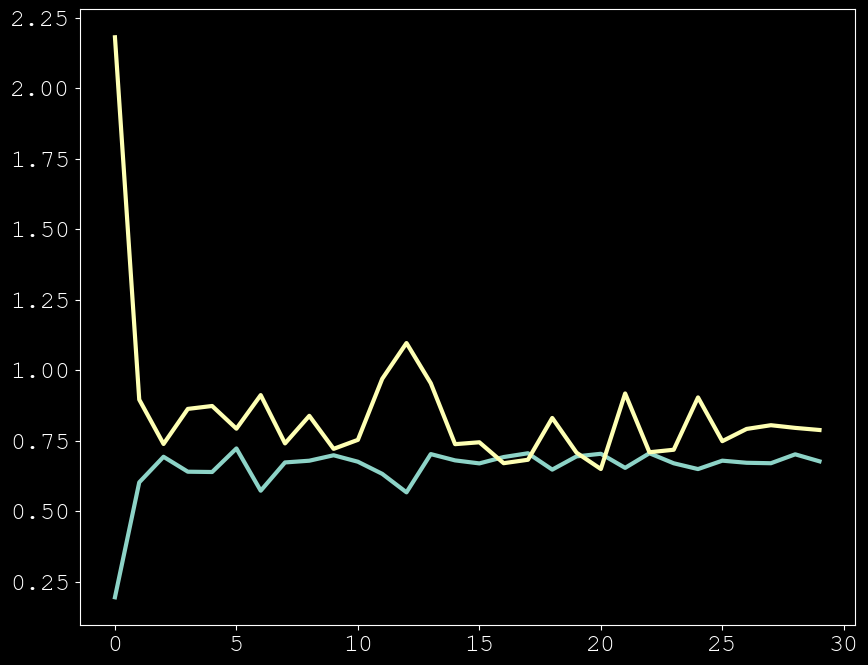

In [10]:
plt.figure(figsize=(10,8))
plt.plot(loss_d.detach())
plt.plot(loss_g.detach())

Now, we can visualize the samples that can be generated by drawing some random latent positions.

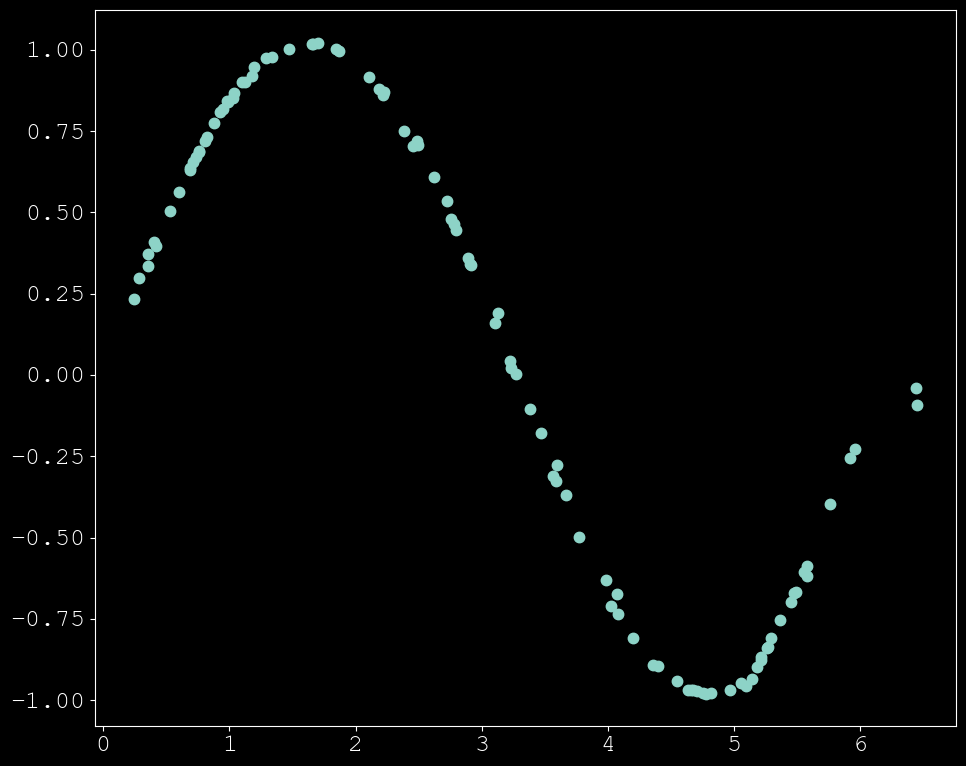

In [11]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.figure(figsize=(10,8))
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()

As we can see, the randomly generated points closely follow the original distribution.

## Handwritten digits generator with GAN

Generative adversarial networks can also generate high-dimensional samples such as images. In this example, we are going to define a GAN to generate images of handwritten digits. For that, we will train the models using the infamous MNIST dataset. 

Again, we are going to make use of `torch` and `torchvision` . Notably, we will use `transforms` to obtain the training data and perform image conversions.

In [12]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

Since this example uses images in the training set, the models need to be more complex, with a larger number of parameters. This makes the training process slower, taking about two minutes per epoch when running on CPU. To reduce the training time, you can use a GPU to train the model if you have one available. The following piece of code allows to automatically select the best device available on your system.

In [13]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Preparing the training data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to convert them to Tensors. Also, in order to ensure adequate learning, it is always best to normalize the data. This is were we make use of `torchvision.transforms` in order to perfom thesse automatically while loading the data.

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

Now, as usual, we can load both the *training* and *testing* data with the datasets objects

In [15]:
batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




45.7%

100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Here we plot some examples of the train set, to better understand the underlying data that we are working with.

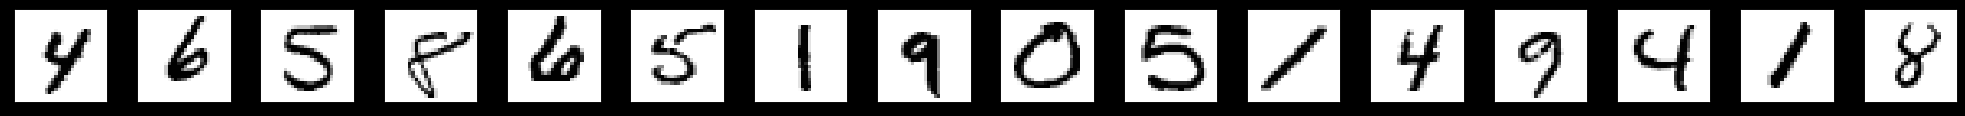

In [24]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()    

### Implementing the discriminator and generator

Here, we are going to first define our *discriminator*. In our case, we will use an MLP, that will be responsible for receiving the images and trying to find which images are fake. The model is defined as follows 

In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients. The vectorization occurs in the first line of `.forward()`, as the call to `x.view()` converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [26]:
discriminator = Discriminator()#.to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image. Here is the complete generator model code:

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh() # Tanh -> normalisation entre [-1 ; 1].
        )

    def forward(self, x):
        #x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [28]:
generator = Generator()#.to(device=device)

As usual, we define the training hyper-parameters that will condition our learning procedure.

In [29]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [30]:
latent_space_samples_plot = torch.randn((batch_size, 100))#.to(device=device)

Epoch: 0 Loss D.: 0.5331904888153076
Epoch: 0 Loss G.: 0.5950902104377747


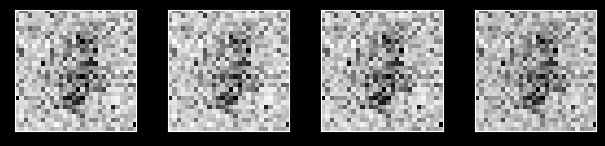

Epoch: 1 Loss D.: 0.46430912613868713
Epoch: 1 Loss G.: 2.5066585540771484


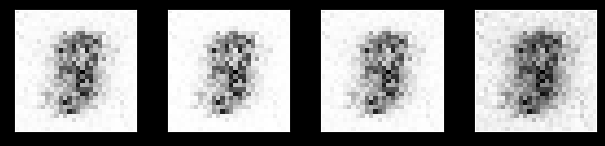

Epoch: 2 Loss D.: 0.46623432636260986
Epoch: 2 Loss G.: 2.754044771194458


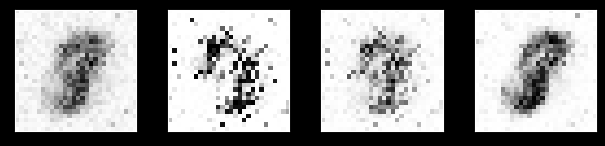

Epoch: 3 Loss D.: 0.15503519773483276
Epoch: 3 Loss G.: 4.294597148895264


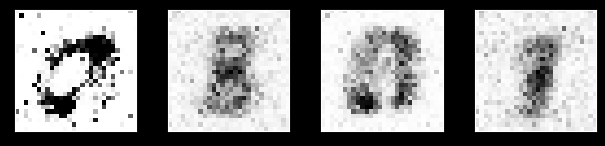

Epoch: 4 Loss D.: 0.34326326847076416
Epoch: 4 Loss G.: 2.5551083087921143


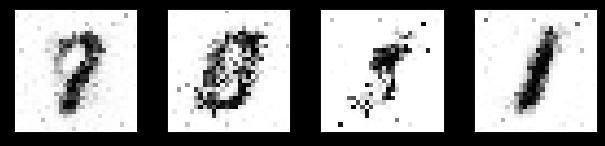

Epoch: 5 Loss D.: 0.31172698736190796
Epoch: 5 Loss G.: 2.345494508743286


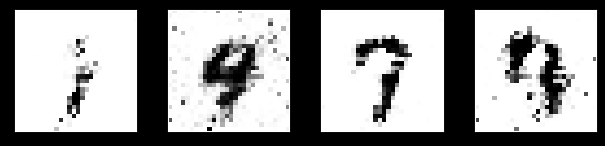

Epoch: 6 Loss D.: 0.4102974236011505
Epoch: 6 Loss G.: 2.1331028938293457


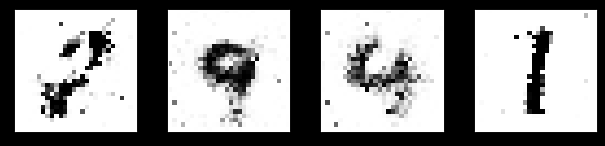

Epoch: 7 Loss D.: 0.37797605991363525
Epoch: 7 Loss G.: 1.4509472846984863


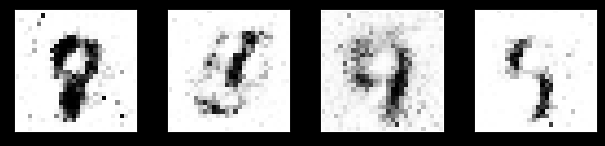

Epoch: 8 Loss D.: 0.3540891408920288
Epoch: 8 Loss G.: 2.348597526550293


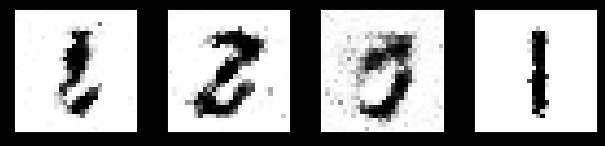

Epoch: 9 Loss D.: 0.25411057472229004
Epoch: 9 Loss G.: 2.2460134029388428


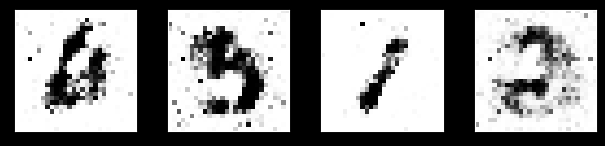

Epoch: 10 Loss D.: 0.3770081102848053
Epoch: 10 Loss G.: 1.621612310409546


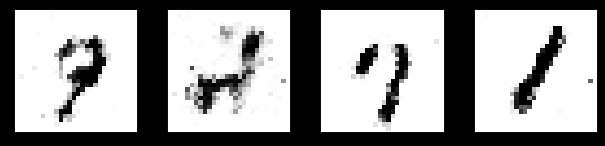

Epoch: 11 Loss D.: 0.25560837984085083
Epoch: 11 Loss G.: 1.8006510734558105


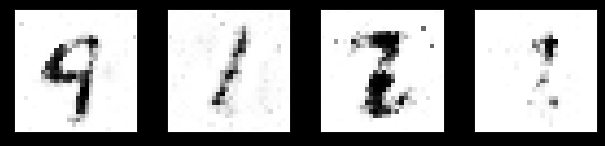

Epoch: 12 Loss D.: 0.45394808053970337
Epoch: 12 Loss G.: 1.8423912525177002


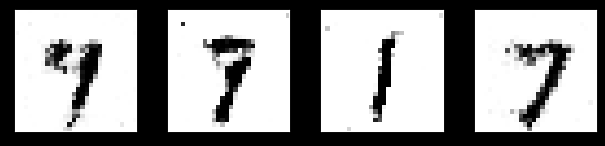

Epoch: 13 Loss D.: 0.3744640648365021
Epoch: 13 Loss G.: 1.615374207496643


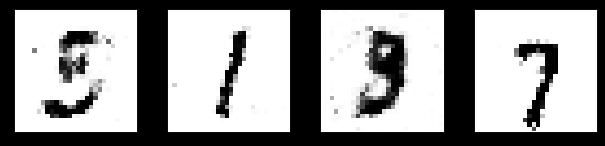

Epoch: 14 Loss D.: 0.47962528467178345
Epoch: 14 Loss G.: 1.43276047706604


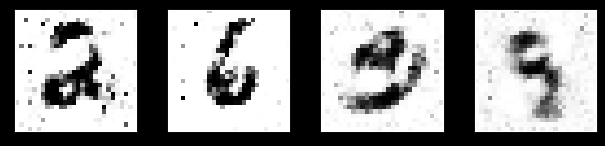

Epoch: 15 Loss D.: 0.5490711331367493
Epoch: 15 Loss G.: 1.0834259986877441


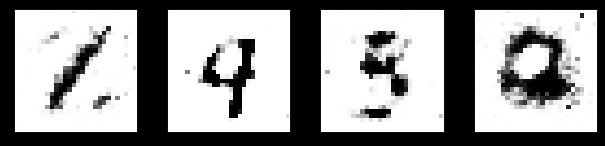

Epoch: 16 Loss D.: 0.5334433317184448
Epoch: 16 Loss G.: 1.0764378309249878


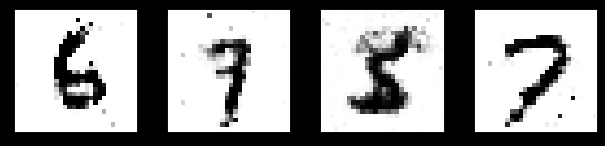

Epoch: 17 Loss D.: 0.650206446647644
Epoch: 17 Loss G.: 1.0202800035476685


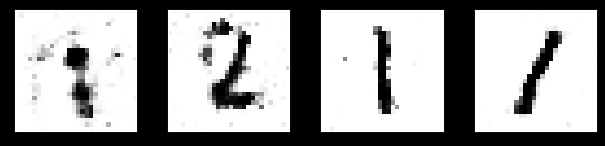

Epoch: 18 Loss D.: 0.5539735555648804
Epoch: 18 Loss G.: 1.131798267364502


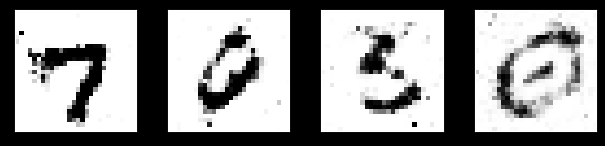

Epoch: 19 Loss D.: 0.45384109020233154
Epoch: 19 Loss G.: 1.2418298721313477


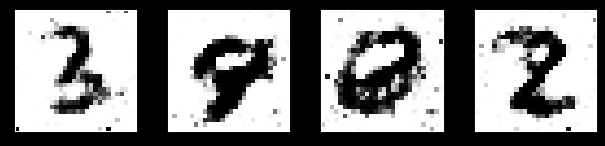

Epoch: 20 Loss D.: 0.6496808528900146
Epoch: 20 Loss G.: 1.0186035633087158


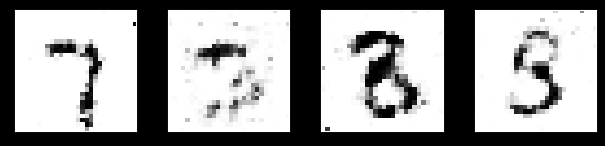

Epoch: 21 Loss D.: 0.5194529891014099
Epoch: 21 Loss G.: 1.547584056854248


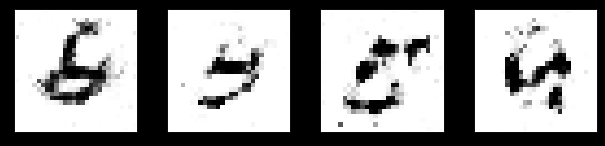

Epoch: 22 Loss D.: 0.5680522918701172
Epoch: 22 Loss G.: 1.0418022871017456


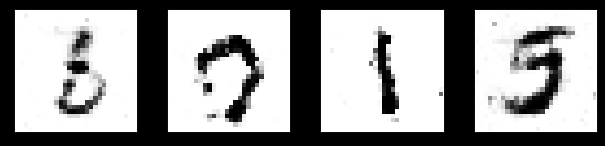

Epoch: 23 Loss D.: 0.6088196039199829
Epoch: 23 Loss G.: 1.3671504259109497


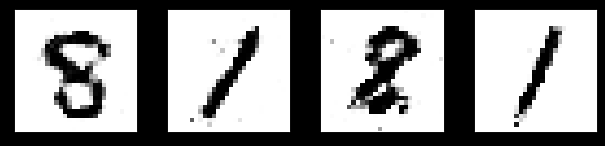

Epoch: 24 Loss D.: 0.5234600305557251
Epoch: 24 Loss G.: 1.2340292930603027


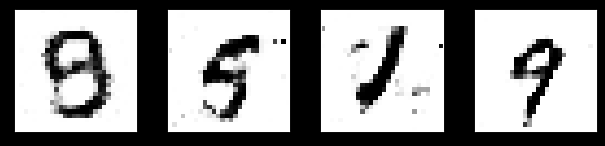

Epoch: 25 Loss D.: 0.5744132995605469
Epoch: 25 Loss G.: 1.1652374267578125


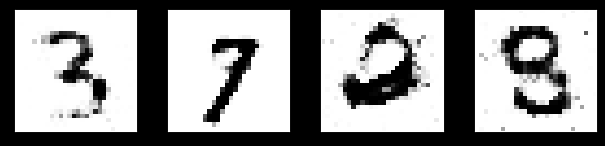

Epoch: 26 Loss D.: 0.5259482264518738
Epoch: 26 Loss G.: 0.8992754220962524


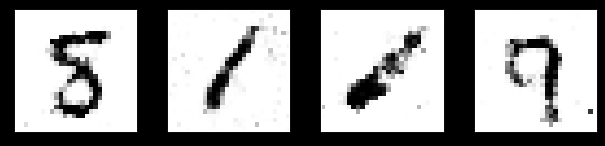

Epoch: 27 Loss D.: 0.6558589935302734
Epoch: 27 Loss G.: 0.8950617909431458


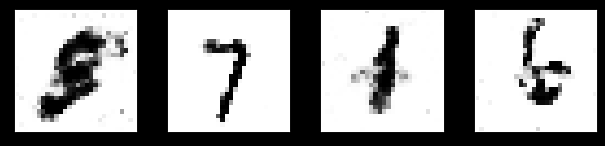

Epoch: 28 Loss D.: 0.5709896087646484
Epoch: 28 Loss G.: 0.9504835605621338


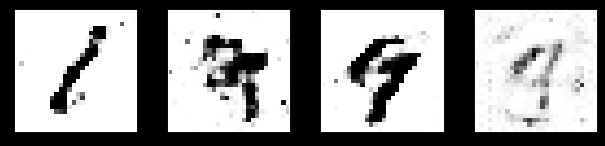

Epoch: 29 Loss D.: 0.6330697536468506
Epoch: 29 Loss G.: 1.0722073316574097


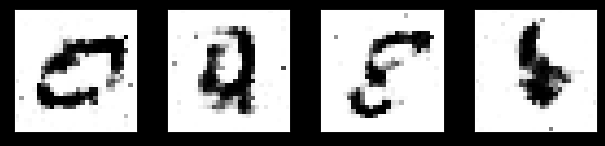

Epoch: 30 Loss D.: 0.47635912895202637
Epoch: 30 Loss G.: 1.1056718826293945


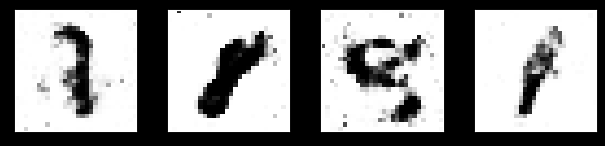

Epoch: 31 Loss D.: 0.6170241832733154
Epoch: 31 Loss G.: 1.0258910655975342


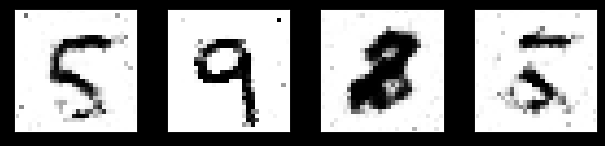

Epoch: 32 Loss D.: 0.6359970569610596
Epoch: 32 Loss G.: 0.9592191576957703


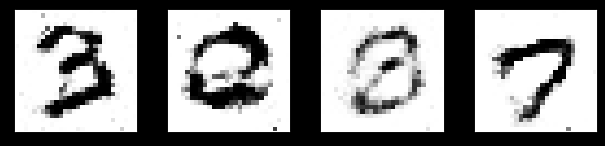

Epoch: 33 Loss D.: 0.5520752668380737
Epoch: 33 Loss G.: 0.9646540284156799


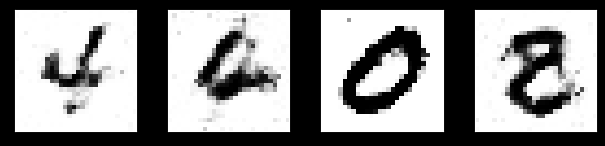

Epoch: 34 Loss D.: 0.5930768251419067
Epoch: 34 Loss G.: 0.8163312077522278


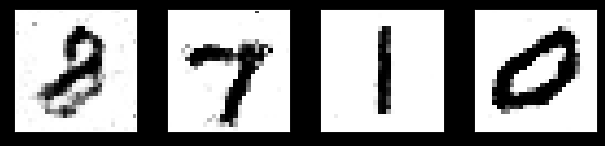

Epoch: 35 Loss D.: 0.6610403060913086
Epoch: 35 Loss G.: 1.0997523069381714


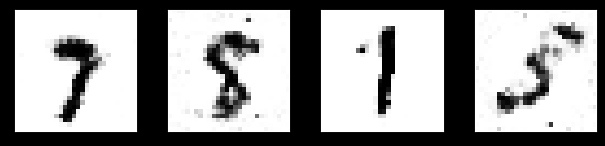

Epoch: 36 Loss D.: 0.6602896451950073
Epoch: 36 Loss G.: 1.0190355777740479


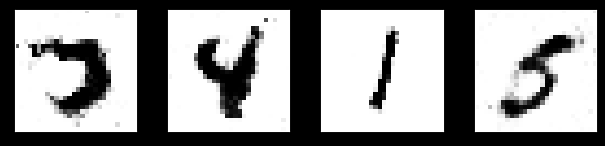

Epoch: 37 Loss D.: 0.588108241558075
Epoch: 37 Loss G.: 1.1423348188400269


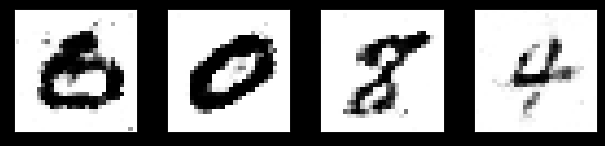

Epoch: 38 Loss D.: 0.668118953704834
Epoch: 38 Loss G.: 0.8048292398452759


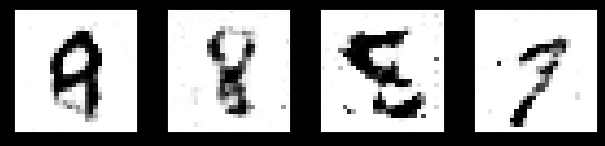

Epoch: 39 Loss D.: 0.7141704559326172
Epoch: 39 Loss G.: 0.8140873312950134


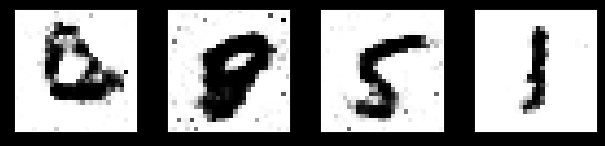

Epoch: 40 Loss D.: 0.5889574289321899
Epoch: 40 Loss G.: 1.0104128122329712


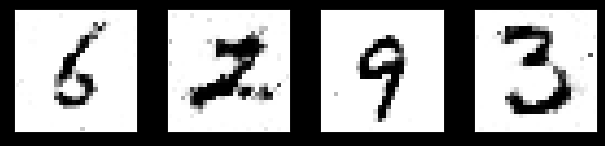

Epoch: 41 Loss D.: 0.6169625520706177
Epoch: 41 Loss G.: 0.925675094127655


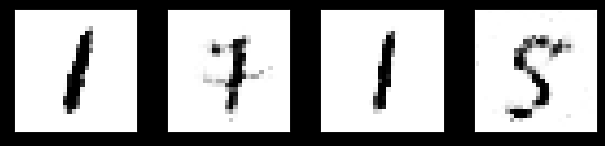

Epoch: 42 Loss D.: 0.6651067733764648
Epoch: 42 Loss G.: 0.95624178647995


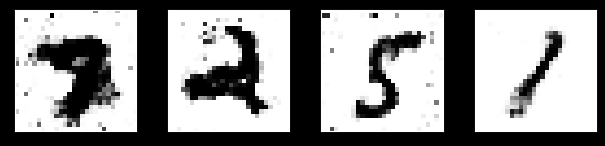

Epoch: 43 Loss D.: 0.6576258540153503
Epoch: 43 Loss G.: 0.7432072162628174


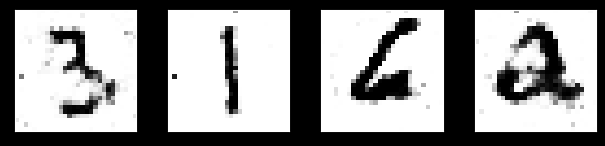

Epoch: 44 Loss D.: 0.6726909875869751
Epoch: 44 Loss G.: 0.704980194568634


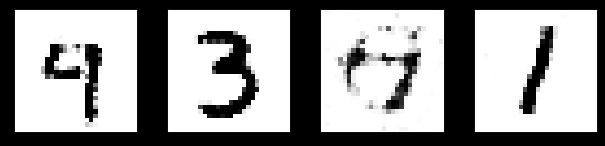

Epoch: 45 Loss D.: 0.6737939119338989
Epoch: 45 Loss G.: 0.8848076462745667


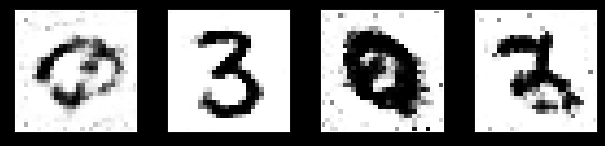

Epoch: 46 Loss D.: 0.5698461532592773
Epoch: 46 Loss G.: 1.1763867139816284


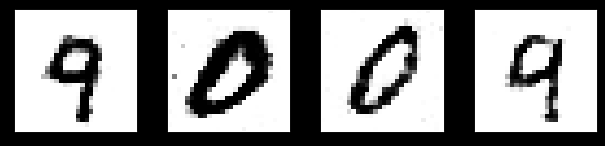

Epoch: 47 Loss D.: 0.5996085405349731
Epoch: 47 Loss G.: 1.0357863903045654


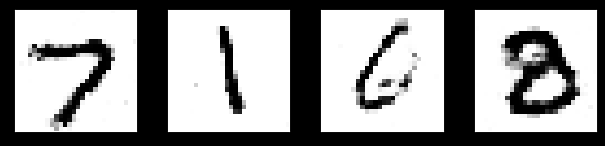

Epoch: 48 Loss D.: 0.5925570726394653
Epoch: 48 Loss G.: 0.8632193803787231


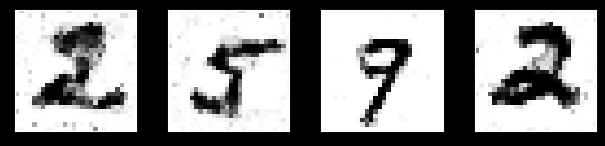

Epoch: 49 Loss D.: 0.597836971282959
Epoch: 49 Loss G.: 0.8931851387023926


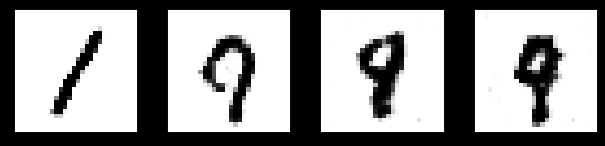

In [31]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):
            # zero the parameter gradients
            optimizer_discriminator.zero_grad()
            
            # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
            batch_size = real_samples.size(0)
            noise = torch.randn(batch_size, 100)#.to(device=device)
            fake_samples = generator(noise)
            
            # forward du discriminator
            disc_real_output = discriminator(real_samples)
            disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas besoin d'avoir accès au gradient du generateur
            
            # calculate the loss for the discriminator
            loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
            
            # calculate the gradient for the discriminator
            loss_discriminator.backward()  
            
            # update the discriminator first
            optimizer_discriminator.step()
            

            
            # zero the parameter gradients
            optimizer_generator.zero_grad()

            # forward du discriminator
            # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
            disc_fake_output = discriminator(fake_samples)
            
            # calculate the loss for the generator
            loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
            
            # calculate the gradient for the discriminator
            loss_generator.backward() 
            
            # update the generator
            optimizer_generator.step()


            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                
                latent_space_samples = torch.randn(batch_size, 100)#.to(device=device)

                generated_samples = generator(latent_space_samples)
                generated_samples = generated_samples.cpu().detach()

                plt.figure()
                for i in range(4):
                    ax = plt.subplot(1, 4, i+1)
                    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                    plt.xticks([])
                    plt.yticks([])
                plt.tight_layout()
                plt.show()

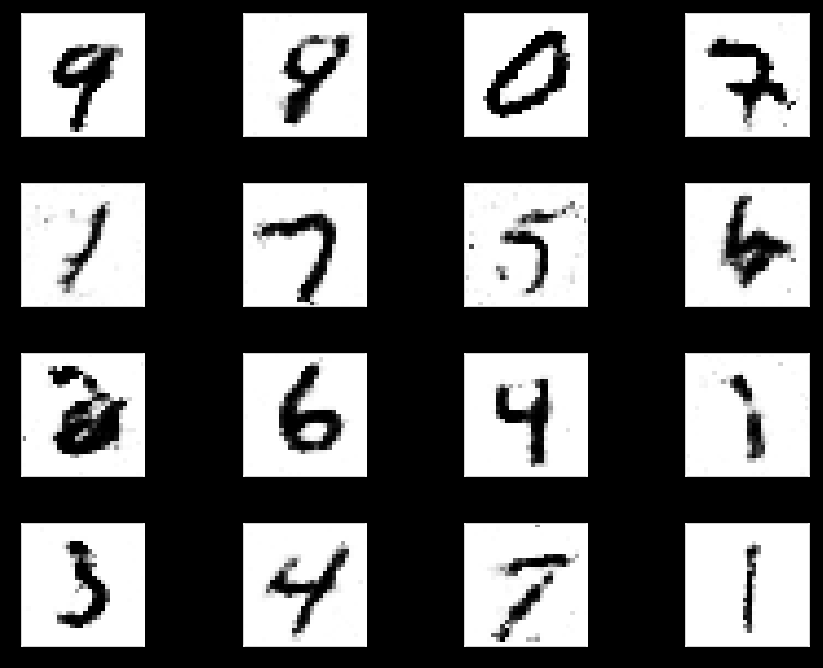

In [32]:
latent_space_samples = torch.randn(batch_size, 100)#.to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [33]:
# Save trained NN parameters
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')